# Jet tagging with Dynamical Graph Convolutional Neural Nets (DGCNNs)

What is a graph?

Essentially, just a structure that has:
- nodes: entities with a set of properties or features
- edges: these connect two nodes, they can be uni- or bi-directional.

Graph networks model graph structures in a neural network architecture.

Why is this useful?

Jets are graphs (or, point clouds).  Each constituent is a node, and edges connect neighbouring constituents.  Jet observables are generally constructed by computing quantities between pairs of particles, for example the angular separation between two particles or the invariant mass of two particles.  Since our networks will serve as jet observables, the graph construction is very natural.  

The constituents in a jet also have very trivial symmetry, permutation invariance.  This means that any observable we construct should not depend on some arbitrary ordering of the jet constituents.  Graph networks are inherently permutation invariant.  If you remember the regression networks we built in tutorials 2 and 4, there we ordered particles by type and $p_T$ to input them to the network.  This was not a permutation invariant construction.

In this tutorial we will learn how to construct graph neural networks using pytorch, and apply them to jet tagging.

For this tutorial I am using the following sources:
- https://pytorch-geometric.readthedocs.io/en/latest/notes/introduction.html#
- https://towardsdatascience.com/program-a-simple-graph-net-in-pytorch-e00b500a642d

Outline:
- Imports and plotting set-up
- Building the dataset
    - Preprocessing
    - Dataloaders
- Data handling in graph networks
- Jets, nodes, and edges
- Message passing $\rightarrow$ generalising convolutions
- Dynamic edge convolutions
- Building a Dynamic Graph Convolutional Neural Network (DGCNN)
- Optimising the DGCNN
- Study the results

Some interesting papers:
- Dynamic Graph CNN for Learning on Point Clouds
    - https://arxiv.org/abs/1801.07829
    - This is the paper that introduces the DGCNN as we know it
- ParticleNet: Jet Tagging via Particle Clouds
    - https://arxiv.org/abs/1902.08570
    - In this paper by Huilin Qu and Loukas Gouskos they apply the DGCNN idea to tagging jets
- An Efficient Lorentz Equivariant Graph Neural Network for Jet Tagging
    - https://arxiv.org/abs/2201.08187v2
    - In this paper by Huilin Qu and others they construct a Lorentz equivariant DGCNN for tagging jets

### Imports

In [1]:
import os
import sys
import random
import time
import numpy as np
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch import nn
from torch.nn import functional as F
from torch.nn import Sequential, Linear, ReLU

#### Plotting set-up

In [97]:
from matplotlib import pyplot as plt
import matplotlib
import warnings
warnings.filterwarnings("ignore")
from matplotlib.lines import Line2D
from matplotlib.font_manager import FontProperties
import matplotlib.colors as mcolors
import colorsys

labelfont = FontProperties()
labelfont.set_family('serif')
labelfont.set_name('Times New Roman')
labelfont.set_size(14)

axislabelfont = FontProperties()
axislabelfont.set_family('serif')
axislabelfont.set_name('Times New Roman')
axislabelfont.set_size(22)

tickfont = FontProperties()
tickfont.set_family('serif')
tickfont.set_name('Times New Roman')
tickfont.set_size(16)

axisfontsize = 16
labelfontsize = 16

plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["mathtext.default"] = "rm"
plt.rcParams['text.usetex'] = True

## Loading the data

We'll be using the top-tagging data again, so let's just load what we saved out before.

In [98]:
X_train = np.load( "tutorial-3-data/TopTagging/x_train_short.npy")
y_train = np.load( "tutorial-3-data/TopTagging/y_train_short.npy")
X_test = np.load( "tutorial-3-data/TopTagging/x_test_short.npy")
y_test = np.load( "tutorial-3-data/TopTagging/y_test_short.npy")
X_val = np.load( "tutorial-3-data/TopTagging/x_val_short.npy")
y_val = np.load( "tutorial-3-data/TopTagging/y_val_short.npy")

## Building the dataset

For each jet we'll keep the $50$ constituents with the highest $p_T$, with each constituent consisting of $(p_T,\eta,\phi)$.
So each constituent in the jet has three features.

### Preprocessing

We still need to preprocess the jets in much the same way as we did for the CNN study.

In [99]:
# Some initial settings
__n_warning__ = 0.7
n_shift_phi, n_shift_eta = 0, 0

# Grid settings
xpixels = np.arange(-2.6, 2.6, 0.029)
ypixels = np.arange(-np.pi, np.pi, 0.035)

# Calculate the pseudorapidity of pixel entries
def eta (pT, pz):
    small = 1e-10
    small_pT = (np.abs(pT) < small)
    small_pz = (np.abs(pz) < small)
    not_small = ~(small_pT | small_pz)
    theta = np.arctan(pT[not_small]/pz[not_small])
    theta[theta < 0] += np.pi
    etas = np.zeros_like(pT)
    etas[small_pz] = 0
    etas[small_pT] = 1e-10
    etas[not_small] = np.log(np.tan(theta/2))
    return etas

# Calculate the azimuthal angle of pixel entries
def phi (px, py):
    """
    phis are returned in rad., np.arctan(0,0)=0 -> zero constituents set to -np.pi
    """
    phis = np.arctan2(py,px)
    phis[phis < 0] += 2*np.pi
    phis[phis > 2*np.pi] -= 2*np.pi
    phis = phis - np.pi 
    return phis

# function to calculate masses
def mass (E,px,py,pz):
    mass = np.sqrt(np.maximum(0.,E**2-px**2-py**2-pz**2))
    return mass

# function to return the image momenta for centroid and principal axis
def img_mom (x, y, weights, x_power, y_power):
    return ((x**x_power)*(y**y_power)*weights).sum()

# returns the jet image
def orig_image (etas, phis, es):
    """
    Gives the value on grid with minimal distance,
    eg. for xpixel = (0,1,2,3,..) eta=1.3 -> xpixel=1, eta=1.6 ->xpixel=2
    """
    z = np.zeros((etas.shape[0],len(xpixels),len(ypixels)))
    in_grid = ~((etas < xpixels[0]) | (etas > xpixels[-1]) | (phis < ypixels[0]) | (phis > ypixels[-1]))
    xcoords = np.argmin(np.abs(etas[:,None,:] - xpixels[None,:,None]),axis=1)
    ycoords = np.argmin(np.abs(phis[:,None,:] - ypixels[None,:,None]),axis=1)
    ncoords = np.repeat(np.arange(etas.shape[0])[:,None],etas.shape[1],axis=1)
    z[ncoords[in_grid],ycoords[in_grid],xcoords[in_grid]] = es[in_grid]
    return z

# preprocess the jet
def preprocessing( x ,y, weights, rotate=True, flip=True ):
    """
    (x,y) are the coordinates and weights the corresponding values, shifts
    centroid to origin, rotates image, so that principal axis is vertical,
    flips image, so that most weights lay in (x<0, y>0)-plane.
    Method for calculating principal axis (similar to tensor of inertia):
    https://en.wikipedia.org/wiki/Image_moment
    here: y=phi, phi has modulo 2*np.pi but it's not been taken care of hear,
    so possible issues with calculating the centroid
    -> pre-shifting of events outside of this function solves the problem
    for iamge-data with Delta_phi < 2*np.pi
    """

    # Shift
    x_centroid = img_mom(x, y, weights, 1, 0) / weights.sum()
    y_centroid = img_mom(x, y, weights, 0, 1)/ weights.sum()
    x = x - x_centroid
    y = y - y_centroid

    # Check if shifting worked, there can be problems with modulo variables like phi (y)
    # x and y are sorted after highest weight, 0-comp. gives hottest event
    # for Jet-like Images Centroid should be close to hottest constituen (pT-sorted arrays)  
    global n_shift_phi
    global n_shift_eta
    if np.abs(x[0]) > __n_warning__:
        n_shift_eta += 1  
    if np.abs(y[0]) > __n_warning__:
        n_shift_phi += 1       

    if rotate:
        #Ccovariant matrix, eigenvectors corr. to principal axis
        u11 = img_mom(x, y, weights, 1, 1) / weights.sum()
        u20 = img_mom(x, y, weights, 2, 0) / weights.sum()
        u02 = img_mom(x, y, weights, 0, 2) / weights.sum()
        cov = np.array([[u20, u11], [u11, u02]])

        # Eigenvalues and eigenvectors of covariant matrix
        evals, evecs = np.linalg.eig(cov)

        # Sorts the eigenvalues, v1, [::-1] turns array around, 
        sort_indices = np.argsort(evals)[::-1]
        e_1 = evecs[:, sort_indices[0]]  # Eigenvector with largest eigenvalue
        e_2 = evecs[:, sort_indices[1]]

        # Theta to x_asix, arctan2 gives correct angle
        theta = np.arctan2(e_1[0], e_1[1])
  
        # Rotation, so that princple axis is vertical
        # anti-clockwise rotation matrix
        rotation = np.matrix([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])
        transformed_mat = rotation * np.stack([x,y])
        x_rot, y_rot = transformed_mat.A
    else: 
        x_rot, y_rot = x, y
  
    # Flipping
    n_flips = 0
    if flip:
        if weights[x_rot<0.].sum() < weights[x_rot>0.].sum():
            x_rot = -x_rot
            n_flips  += 1
        if weights[y_rot<0.].sum() > weights[y_rot>0.].sum():
            y_rot = -y_rot
            n_flips += 1
            
    return x_rot, y_rot

In [100]:
# function to convert the jet to a particle cloud
def constit_to_cloud( jets, n_constit, norm, rotate, flip ):
    
    print( "Crop constituents" )
    jets = jets[:,0:n_constit,:]
    
    print( "Calculating pT" )
    E     = jets[:,:,0]
    pxs   = jets[:,:,1]
    pys   = jets[:,:,2]
    pzs   = jets[:,:,3]
    pT    = np.sqrt( pxs**2+pys**2 )
    
    print( "Calculating eta" )
    etas  = eta( pT, pzs )
    
    print( "Calculating phi" )
    phis  = phi( pxs, pys )
    
    print( "Calculating the mass" )
    E_tot = E.sum( axis=1 )
    px_tot = pxs.sum( axis=1 )
    py_tot = pys.sum( axis=1 )
    pz_tot = pzs.sum( axis=1 )
    j_mass = mass( E_tot, px_tot, py_tot, pz_tot )
    
    print( "Pre-shifting the phis" )
    phis = ( phis.T - phis[:,0] ).T
    phis[phis < -np.pi] += 2*np.pi
    phis[phis > np.pi] -= 2*np.pi
    
    print( "Using pT as weight" )
    weights = pT
    
    print( "Preprocessing" )
    
    for i in range( np.shape(etas)[0] ):
        etas[i,:], phis[i,:] = preprocessing( etas[i,:], phis[i,:], weights[i,:], rotate, flip )
    
    cloud = np.stack( [ pT/np.mean(pT), etas, phis ], axis=2 )
    
    return cloud

In [101]:
z_train = constit_to_cloud( X_train, 50, True, True, True )
z_val = constit_to_cloud( X_val, 50, True, True, True )
z_test = constit_to_cloud( X_test, 50, True, True, True )

Crop constituents
Calculating pT
Calculating eta
Calculating phi
Calculating the mass
Pre-shifting the phis
Using pT as weight
Preprocessing
Crop constituents
Calculating pT
Calculating eta
Calculating phi
Calculating the mass
Pre-shifting the phis
Using pT as weight
Preprocessing
Crop constituents
Calculating pT
Calculating eta
Calculating phi
Calculating the mass
Pre-shifting the phis
Using pT as weight
Preprocessing


In [102]:
print( "Train data shape: " + str(z_train.shape) )
print( "Val data shape: " + str(z_val.shape) )
print( "Test data shape: " + str(z_test.shape) )

Train data shape: (30000, 50, 3)
Val data shape: (30000, 50, 3)
Test data shape: (30000, 50, 3)


In [103]:
z_train_p = torch.Tensor( z_train )
z_val_p = torch.Tensor( z_val )
z_test_p = torch.Tensor( z_test )
y_train_p = torch.Tensor( y_train )
y_val_p = torch.Tensor( y_val )
y_test_p = torch.Tensor( y_test )

### Dataloaders

In [104]:
class topcloud_dataset( Dataset ):
    
    def __init__( self, data, labels ):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

In [105]:
trn_dataset = topcloud_dataset( z_train_p, y_train_p.unsqueeze(-1) )
val_dataset = topcloud_dataset( z_val_p, y_val_p.unsqueeze(-1) )
tst_dataset = topcloud_dataset( z_test_p, y_test_p.unsqueeze(-1) )

In [106]:
trn_dataloader = DataLoader( trn_dataset, batch_size=64, shuffle=True )
val_dataloader = DataLoader( val_dataset, batch_size=64, shuffle=True )
tst_dataloader = DataLoader( tst_dataset, batch_size=64, shuffle=True )

## Data handling in graph networks

Data is handled slightly differently in graph networks than in the networks we studied previously, this is because the data now has two different attributes, the nodes and edges.  The `torch-geometric` package has it's own Data class.

In [17]:
from torch_geometric.data import Data

As an example, let's create a graph with 3 nodes and 4 edges.  Remember that edges can generally go in either direction.

<img src="simple-graph-image.png" width="500"/>

In [18]:
edge_index = torch.tensor( [[0, 1, 1, 2], 
                            [1, 0, 2, 1]], 
                          dtype=torch.long )

x = torch.tensor( [[-1], [0], [1]], dtype=torch.float )

data = Data( x=x, edge_index=edge_index )

We can check the data we have defined:

In [19]:
print( "number of nodes: " + str(data.num_nodes) )
print( "number of edges: " + str(data.num_edges) )
print( "number of node features: " + str(data.num_node_features) )
print( "number of edge features: " + str(data.num_edge_features) )
print( "keys: " + str(data.keys) )

number of nodes: 3
number of edges: 4
number of node features: 1
number of edge features: 0
keys: ['x', 'edge_index']


But this is awkward.  Ideally the `edge_index` would be a list of tuples, with each tuple specifying the start and end point of the edge.

So we instead define it as:

In [20]:
edge_index = torch.tensor( [[0, 1],
                            [1, 0],
                            [1, 2],
                            [2, 1]], 
                          dtype=torch.long )

x = torch.tensor( [[-1], [0], [1]], dtype=torch.float )

data = Data( x=x, edge_index=edge_index.t().contiguous() )

The `.t()` here just applies a transpose, and `.contiguous()` ensures that the data has the correct memory format.

We can again check the data:

In [21]:
print( "number of nodes: " + str(data.num_nodes) )
print( "number of edges: " + str(data.num_edges) )
print( "number of node features: " + str(data.num_node_features) )
print( "number of edge features: " + str(data.num_edge_features) )
print( "keys: " + str(data.keys) )

number of nodes: 3
number of edges: 4
number of node features: 1
number of edge features: 0
keys: ['x', 'edge_index']


## Jets, nodes, and edges

The jets we consider usually have $\mathcal{O}(10^2)$ constituents, which would mean $\mathcal{O}(10^4)$ edges.
This is a lot, and it would mean we need a graph neural network with many parameters.
The way around this is to only consider sub-graphs of neighbouring nodes within the complete graph, i.e. we only connect neighbouring nodes by edges.
The nodes which are considered as neughbouring can be determined by any clustering algorithm, in practice the k-means algorithm is usually used.
This funcitonality is defined in the `knn` class within the `torch_cluster` package, or in the `knn_graph` class within the `torch_geometric.nn` package.
The latter returns a graph in the correct format, so we'll use that.

So we've discussed the structure of graphs and graph networks, but we haven't explained what they do with the data.
The basic function of a graph network is the Edge Convolution, this funcitonality is coded in the `EdgeConv` class in `torch_geometric.nn.conv`.
However this requires that we give the network the edges in the format discussed above.
We will instead use the Dynamic Edge Convolution function, which automatically performs the k-means clustering to determine which are the neighbouring nodes.
This functionality is coded in the `DynamicEdgeConv` class in the same package.

## Message passing $\rightarrow$ generalising convolutions

But let's take a step back and think about convolutions in more detail.

We have studied convolutional networks in the context of jet images, where the convolutional operator scans over teh image pixels in a discrete manner.
Now we work with point clouds, or graphs, where the data is less structured and so the idea of a convolution becomes more complicated.

The generalisation of a convolution to irregular domains is usually encoded in 'message passing' (or 'neighbourhood aggregation') schemes.  

The graph network is constructed of layers labelled by $k$.
At each layer the data is again treated as a graph, so that as we move through the network the graph is being altered by each layer.
We denote the features of node $i$ in layer $(k-1)$ of the graph network as ${\bf x}_i^{(k-1)}$, and the edge features from node $j$ to $i$ as ${\bf e}_{j,i}$.
The message passing in a graph network is then expressed as:

$
{\bf x}_i^{(k)} = \gamma^{(k)} \left( {\bf x}_i^{(k-1)}, \square_{j\in\mathcal{N}(i)} \phi^{(k)}\left( {\bf x}_i^{(k)}, {\bf x}_j^{(k)}, {\bf e}_{j,i} \right) \right)
$

where $\gamma$ and $\phi$ are some differentiable functions, i.e. neural networks, and $\square$ is a permutation invariant function like a sum, mean, or a max.
$\mathcal{N}(i)$ is the function which defines the nearest neighbours, i.e. k-means or something similar.

The `MessagePassing` class in `torch_geometric.nn` is the base class for the graph convolution functions.
To define a message passing layer the user needs to define the networks $\phi$ (`.message()`) and $\gamma$ (`.update()`), and the aggregation function $\square$ (e.g. `aggr="mean"`).

## Dynamic edge convolutions

Edge convolutions are just a specific message passing choice.

The choice is:

$
{\bf x}_i^{(k)} = \text{mean}_{j\in \mathcal{N}(i)} h_{\Theta}\left( {\bf x}_i^{(k-1)}, {\bf x}_j^{(k-1)} - {\bf x}_i^{(k-1)} \right)
$

where $h_{\Theta}$ is just a neural network.

We could simply load the classes for `EdgeConv` and `DynamicEdgeConv`, but let's have a look at them here.
The edge convolutions in pytorch are implemented using the `MessagePassing` class as follows:

In [107]:
from typing import Callable, Optional, Union

import torch
from torch import Tensor

from torch_geometric.nn.inits import reset
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.typing import Adj, OptTensor, PairOptTensor, PairTensor
    
class EdgeConv( MessagePassing ):
    r"""The edge convolutional operator from the `"Dynamic Graph CNN for
    Learning on Point Clouds" <https://arxiv.org/abs/1801.07829>`_ paper

    .. math::
        \mathbf{x}^{\prime}_i = \sum_{j \in \mathcal{N}(i)}
        h_{\mathbf{\Theta}}(\mathbf{x}_i \, \Vert \,
        \mathbf{x}_j - \mathbf{x}_i),

    where :math:`h_{\mathbf{\Theta}}` denotes a neural network, *.i.e.* a MLP.

    Args:
        nn (torch.nn.Module): A neural network :math:`h_{\mathbf{\Theta}}` that
            maps pair-wise concatenated node features :obj:`x` of shape
            :obj:`[-1, 2 * in_channels]` to shape :obj:`[-1, out_channels]`,
            *e.g.*, defined by :class:`torch.nn.Sequential`.
        aggr (string, optional): The aggregation scheme to use
            (:obj:`"add"`, :obj:`"mean"`, :obj:`"max"`).
            (default: :obj:`"max"`)
        **kwargs (optional): Additional arguments of
            :class:`torch_geometric.nn.conv.MessagePassing`.

    Shapes:
        - **input:**
          node features :math:`(|\mathcal{V}|, F_{in})` or
          :math:`((|\mathcal{V}|, F_{in}), (|\mathcal{V}|, F_{in}))`
          if bipartite,
          edge indices :math:`(2, |\mathcal{E}|)`
        - **output:** node features :math:`(|\mathcal{V}|, F_{out})` or
          :math:`(|\mathcal{V}_t|, F_{out})` if bipartite
    """
    
    def __init__(self, nn: Callable, aggr: str = 'max', **kwargs):
        super().__init__(aggr=aggr, **kwargs)
        self.nn = nn
        self.reset_parameters()

    def reset_parameters(self):
        reset(self.nn)

    def forward(self, x: Union[Tensor, PairTensor], edge_index: Adj) -> Tensor:
        """"""
        if isinstance(x, Tensor):
            x: PairTensor = (x, x)
        # propagate_type: (x: PairTensor)
        return self.propagate(edge_index, x=x, size=None)


    def message(self, x_i: Tensor, x_j: Tensor) -> Tensor:
        return self.nn(torch.cat([x_i, x_j - x_i], dim=-1))

    def __repr__(self) -> str:
        return f'{self.__class__.__name__}(nn={self.nn})'

This requires us to provide the `edge_index` information in the forward pass.
However as we discussed before we want to determine the nearest neighbours on the fly using dynamics edge convolutions.
Pytorch does this as follows:

In [108]:
from torch_cluster import knn

class DynamicEdgeConv( MessagePassing ):
    r"""The dynamic edge convolutional operator from the `"Dynamic Graph CNN
    for Learning on Point Clouds" <https://arxiv.org/abs/1801.07829>`_ paper
    (see :class:`torch_geometric.nn.conv.EdgeConv`), where the graph is
    dynamically constructed using nearest neighbors in the feature space.

    Args:
        nn (torch.nn.Module): A neural network :math:`h_{\mathbf{\Theta}}` that
            maps pair-wise concatenated node features :obj:`x` of shape
            `:obj:`[-1, 2 * in_channels]` to shape :obj:`[-1, out_channels]`,
            *e.g.* defined by :class:`torch.nn.Sequential`.
        k (int): Number of nearest neighbors.
        aggr (string): The aggregation operator to use (:obj:`"add"`,
            :obj:`"mean"`, :obj:`"max"`). (default: :obj:`"max"`)
        num_workers (int): Number of workers to use for k-NN computation.
            Has no effect in case :obj:`batch` is not :obj:`None`, or the input
            lies on the GPU. (default: :obj:`1`)
        **kwargs (optional): Additional arguments of
            :class:`torch_geometric.nn.conv.MessagePassing`.

    Shapes:
        - **input:**
          node features :math:`(|\mathcal{V}|, F_{in})` or
          :math:`((|\mathcal{V}|, F_{in}), (|\mathcal{V}|, F_{in}))`
          if bipartite,
          batch vector :math:`(|\mathcal{V}|)` or
          :math:`((|\mathcal{V}|), (|\mathcal{V}|))`
          if bipartite *(optional)*
        - **output:** node features :math:`(|\mathcal{V}|, F_{out})` or
          :math:`(|\mathcal{V}_t|, F_{out})` if bipartite
    """
    
    def __init__(self, nn: Callable, k: int, aggr: str = 'max',
                 num_workers: int = 1, **kwargs):
        super().__init__(aggr=aggr, flow='source_to_target', **kwargs)

        if knn is None:
            raise ImportError('`DynamicEdgeConv` requires `torch-cluster`.')

        self.nn = nn
        self.k = k
        self.num_workers = num_workers
        self.reset_parameters()

    def reset_parameters(self):
        reset(self.nn)

    def forward(
            self, x: Union[Tensor, PairTensor],
            batch: Union[OptTensor, Optional[PairTensor]] = None) -> Tensor:
        # type: (Tensor, OptTensor) -> Tensor  # noqa
        # type: (PairTensor, Optional[PairTensor]) -> Tensor  # noqa
        """"""
        if isinstance(x, Tensor):
            x: PairTensor = (x, x)

        if x[0].dim() != 2:
            raise ValueError("Static graphs not supported in DynamicEdgeConv")

        b: PairOptTensor = (None, None)
        if isinstance(batch, Tensor):
            b = (batch, batch)
        elif isinstance(batch, tuple):
            assert batch is not None
            b = (batch[0], batch[1])

        edge_index = knn(x[0], x[1], self.k, b[0], b[1]).flip([0])

        # propagate_type: (x: PairTensor)
        return self.propagate(edge_index, x=x, size=None)


    def message(self, x_i: Tensor, x_j: Tensor) -> Tensor:
        return self.nn(torch.cat([x_i, x_j - x_i], dim=-1))

    def __repr__(self) -> str:
        return f'{self.__class__.__name__}(nn={self.nn}, k={self.k})'

Let's test it.

To define the dynamic edge convolutional layer we need to supply it with a neural network ($h_{\Theta}$) and a number of clusters ($k$) for the k-means clustering.  The dimensions of the neural network must be ( 2 x input_features, output_features ), because we concatenate $x_i$ and $x_j - x_i$.

In [31]:
nnt = nn.Linear( 2*3, 12 )
dec = DynamicEdgeConv( nnt, 5)

In [32]:
dec

DynamicEdgeConv(nn=Linear(in_features=6, out_features=12, bias=True), k=5)

Now let's pass through a random 'jet' with 40 constituents:

In [33]:
xt = torch.rand( 50, 3 )

In [34]:
dec( xt ).shape

torch.Size([50, 12])

And the output has the dimension specified by the NN we defined.

Let's do the same for EdgeConv.

But here we need to supply edges, for this we'll just generate a random tensor of integers between 0 and 50 with shape (2,50).

In [46]:
nnt = nn.Linear( 2*3, 12 )
ec = EdgeConv( nnt, aggr='mean' )
edges = torch.randint( 50, [2,10] )

In [47]:
edges

tensor([[18, 29, 36, 42, 25, 38, 36, 21, 37, 33],
        [ 4,  2, 31, 47, 12,  2, 26, 29, 21,  3]])

In [50]:
ec( xt, edges ).shape

torch.Size([50, 12])

Both the EdgeConv and DynamicEdgeConv return a point cloud.
In a graph neural network each EdgeConv layer will return another point cloud, with which we will determine where to place the edges, and then pass through another EndgeConv layer to get another point cloud.
This whole procedure is completely permutation equivariant, i.e. a change in the order of the inputs will only result is a change in the order of the outputs.
In the end we want to aggregate over the point cloud to get a permutation invariant result.
In this example we would simply aggregate over the dimension 50 row to get a 12 dimensional output.
For example:

In [51]:
ec( xt, edges ).mean( dim=0 )

tensor([ 0.0028,  0.0043, -0.0206, -0.0314, -0.0160, -0.0774,  0.0048,  0.0691,
        -0.0618,  0.0452,  0.0293,  0.0545], grad_fn=<MeanBackward1>)

To see that this is invariant we take the simpler example from before:

In [74]:
edge_index = torch.tensor( [[0, 1],
                            [1, 0],
                            [1, 2],
                            [2, 1]], 
                          dtype=torch.long )

x = torch.tensor( [[-1], [0], [1]], dtype=torch.float )

In [91]:
ec2( x, edge_index.t().contiguous() )

tensor([[ 1.0610,  0.6449,  0.2553, -0.6052],
        [ 0.2668, -0.2579,  0.5094,  0.0332],
        [-0.5274, -1.1607,  0.7636,  0.6716]], grad_fn=<DivBackward0>)

Now permute the first two nodes:

In [87]:
x_p = torch.tensor( [[0], [-1], [1]], dtype=torch.float )
edge_index_p = torch.tensor( [[1, 0],
                            [0, 1],
                            [0, 2],
                            [2, 0]], 
                          dtype=torch.long )

In [88]:
ec2( x_p, edge_index_p.t().contiguous() )

tensor([[ 0.2668, -0.2579,  0.5094,  0.0332],
        [ 1.0610,  0.6449,  0.2553, -0.6052],
        [-0.5274, -1.1607,  0.7636,  0.6716]], grad_fn=<DivBackward0>)

Now we see that the first two rows have been permuted, so the result is permutation equivariant, as expected.

And if we aggregate:

In [89]:
ec2( x, edge_index.t().contiguous() ).mean( dim=0 )

tensor([ 0.2668, -0.2579,  0.5094,  0.0332], grad_fn=<MeanBackward1>)

In [90]:
ec2( x_p, edge_index_p.t().contiguous() ).mean( dim=0 )

tensor([ 0.2668, -0.2579,  0.5094,  0.0332], grad_fn=<MeanBackward1>)

We see that the result is permutation invariant.

In the graph neural network this would then be passed to a fully connected network and propagated to the final layer.

## Building a Dynamic Graph Convolutional Neural Network (DGCNN)

In [142]:
class JetNet( torch.nn.Module ):
    
    def __init__( self ):
        super( JetNet, self ).__init__()
        
        self.net1 = nn.Sequential(
            nn.Linear( 2*3, 32 ),
            nn.ReLU(),
            nn.Linear( 32, 32 ),
            nn.ReLU(),
            nn.Linear( 32, 16 )
        )

        self.net2 = nn.Sequential(
            nn.Linear( 2*16, 32 ),
            nn.ReLU(),
            nn.Linear( 32, 32 ),
            nn.ReLU(),
            nn.Linear( 32, 32 )
        )

        self.conv1 = DynamicEdgeConv( self.net1, 10, aggr='mean' )
        
        self.conv2 = DynamicEdgeConv( self.net2, 10, aggr='mean' )
        
        self.net3 = nn.Sequential(
            nn.Linear( 32, 10 ),
            nn.ReLU(),
            nn.Linear( 10, 1 )
        )

    def forward( self, data ):

        x = self.conv1( data )
        x = F.relu( x )
        x = F.dropout( x, p=0.1, training=self.training )
        x = self.conv2( x )
        x = F.relu( x )
        x = x.mean(0)
        x = self.net3( x )

        return F.sigmoid( x )

Now let's just pass some data through it to make sure this works:

In [143]:
testnet = JetNet()

In [144]:
xt = torch.rand( 50, 3 )

In [145]:
testnet( xt ).shape

torch.Size([1])

This is the dimension of the output that we expect.

We can view the network elements by just calling it:

In [146]:
testnet

JetNet(
  (net1): Sequential(
    (0): Linear(in_features=6, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=16, bias=True)
  )
  (net2): Sequential(
    (0): Linear(in_features=32, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=32, bias=True)
  )
  (conv1): DynamicEdgeConv(nn=Sequential(
    (0): Linear(in_features=6, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=16, bias=True)
  ), k=10)
  (conv2): DynamicEdgeConv(nn=Sequential(
    (0): Linear(in_features=32, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=32, bias=True)

## Optimising the DGCNN

In this tutorial I have used a standard pytorch Dataloader to store the data, just as we've done in previous tutorials.
But to batch the data for DGCNNs constructed using `torch_geometry` we would need to use the `Data` package within `torch_geometry`.
I have resolved this below (in an unstatisfactory way) by manually looping over each jet each batch.
This fixes the problem, but would certainly slow the code down if we were to use a GPU.
In practice we should use the correct Dataloaders.

In [114]:
loss_fn = nn.BCELoss()
batch_size = 64

In [115]:
def train_epoch( dataloader, model, loss_fn, optimizer ):
    
    size = len( dataloader.dataset )
    
    for batch, (X_batch, y_batch) in enumerate( dataloader ):
        
        loss = 0.0
        
        for (X, y) in zip( X_batch, y_batch ):

            # pass data through network
            pred = model(X)

            # compute loss
            loss += loss_fn( pred, y ) / batch_size

        # reset gradients in optimizer
        optimizer.zero_grad()
        
        # compute gradients
        loss.backward()
        
        # update weights with optimizer
        optimizer.step()
        
        # print the training loss every 100 updates
        if batch % 100 == 0:
            #loss, current = loss.item(), batch * len(X)
            current = batch * len( X_batch )
            print( f"current batch loss: {loss:>7f}  [{current:>5d}/{size:>5d}]" )

In [116]:
def val_pass( dataloader, model, loss_fn ):
    
    size = len( dataloader.dataset )
    num_batches = len( dataloader )
    vl = 0.0

    with torch.no_grad():
        for X_batch, y_batch in dataloader:
            for (X, y) in zip(X_batch,y_batch):
                pred = model( X )
                vl += loss_fn( pred, y ).item() / batch_size

    vl /= num_batches
    print( f"avg val loss per batch: {vl:>8f}" )
    
    return vl

def trn_pass( dataloader, model, loss_fn ):
    
    size = len( dataloader.dataset )
    num_batches = len( dataloader )
    tl = 0.0

    with torch.no_grad():
        for X_batch, y_batch in dataloader:
            for (X, y) in zip(X_batch,y_batch):
                pred = model( X )
                tl += loss_fn( pred, y ).item() / batch_size

    tl /= num_batches
    print( f"avg trn loss per batch: {tl:>8f}" )
    
    return tl

Now we can train the network.
Graph networks can be slow, especially on a laptop CPU.
So I only train it here for 10 epochs.
But you'll see that even with 10 epochs we get quite a good performance.

In [147]:
# a useful function to present things clearer
def separator():
    print( "-----------------------------------------------" )

epochs = 10

# re-initialise the model and the optimizer
model = JetNet()
learning_rate = 0.001
optimizer = torch.optim.Adam( model.parameters(), lr=learning_rate )
separator()
print( "model architecture ")
separator()
print( model )

# track train and val losses
trn_losses = []
val_losses = []

for t in range(epochs):
    separator()
    print( f"Epoch {t+1}" )
    separator()
    train_epoch( trn_dataloader, model, loss_fn, optimizer )
    separator()
    model.eval()
    trn_loss = trn_pass( trn_dataloader, model, loss_fn )
    trn_losses.append( trn_loss )
    separator()
    val_loss = val_pass( val_dataloader, model, loss_fn )
    val_losses.append( val_loss )
    model.train()
    separator()
    print( "|" )
    
print("Done!")

-----------------------------------------------
model architecture 
-----------------------------------------------
JetNet(
  (net1): Sequential(
    (0): Linear(in_features=6, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=16, bias=True)
  )
  (net2): Sequential(
    (0): Linear(in_features=32, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=32, bias=True)
  )
  (conv1): DynamicEdgeConv(nn=Sequential(
    (0): Linear(in_features=6, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=16, bias=True)
  ), k=10)
  (conv2): DynamicEdgeConv(nn=Sequential(
    (0): Linear(in_features=32, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_

## Study the results

In [149]:
model.eval()

JetNet(
  (net1): Sequential(
    (0): Linear(in_features=6, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=16, bias=True)
  )
  (net2): Sequential(
    (0): Linear(in_features=32, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=32, bias=True)
  )
  (conv1): DynamicEdgeConv(nn=Sequential(
    (0): Linear(in_features=6, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=16, bias=True)
  ), k=10)
  (conv2): DynamicEdgeConv(nn=Sequential(
    (0): Linear(in_features=32, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=32, bias=True)

In [151]:
trn_loss = trn_pass( trn_dataloader, model, loss_fn )
val_loss = val_pass( val_dataloader, model, loss_fn )
test_loss = val_pass( tst_dataloader, model, loss_fn )

separator()
print("Final evaluation of performance:")
print("BCE-loss on train dataset: {}".format(trn_loss))
print("BCE-loss on validation dataset: {}".format(val_loss))
print("BCE-loss on test dataset: {}".format(test_loss))
separator()

avg trn loss per batch: 0.249912
avg val loss per batch: 0.247864
avg val loss per batch: 0.249365
-----------------------------------------------
Final evaluation of performance:
BCE-loss on train dataset: 0.24991207184104408
BCE-loss on validation dataset: 0.24786406089310592
BCE-loss on test dataset: 0.2493650476925356
-----------------------------------------------


In [152]:
samp_size = 10000

train_pred = []
for z in z_train[:samp_size]:
    train_pred.append( model( torch.Tensor(z) ).detach() )

val_pred = []
for z in z_val[:samp_size]:
    val_pred.append( model( torch.Tensor(z) ).detach() )

test_pred = []
for z in z_test[:samp_size]:
    test_pred.append( model( torch.Tensor(z) ).detach() )

In [153]:
train_pred_lab = torch.round( torch.Tensor( train_pred[:samp_size] ) )
val_pred_lab = torch.round( torch.Tensor( val_pred[:samp_size] ) )
test_pred_lab = torch.round( torch.Tensor( test_pred[:samp_size] ) )

train_correct = ( train_pred_lab == torch.Tensor( y_train[:samp_size] ) ).sum().item()
val_correct = ( val_pred_lab == torch.Tensor( y_val[:samp_size] ) ).sum().item()
test_correct = ( test_pred_lab == torch.Tensor( y_test[:samp_size] ) ).sum().item()

In [154]:
separator()
print('Evaluation of accuracy: ')
print('Accuracy on training dataset: {:.1f} %'.format(train_correct*100/len(train_pred)))
print('Accuracy on validation dataset: {:.1f} %'.format(val_correct*100/len(val_pred)))
print('Accuracy on test dataset: {:.1f} %'.format(test_correct*100/len(test_pred)))
separator()

-----------------------------------------------
Evaluation of accuracy: 
Accuracy on training dataset: 89.9 %
Accuracy on validation dataset: 90.3 %
Accuracy on test dataset: 89.9 %
-----------------------------------------------


In [155]:
train_pred = np.array( train_pred )
val_pred = np.array( val_pred )
test_pred = np.array( test_pred )

In [156]:
from sklearn.metrics import roc_curve, roc_auc_score

def closest_point(array, tpr_p=0.3):
    dist = ((array-tpr_p)**2)
    return np.argmin(dist)

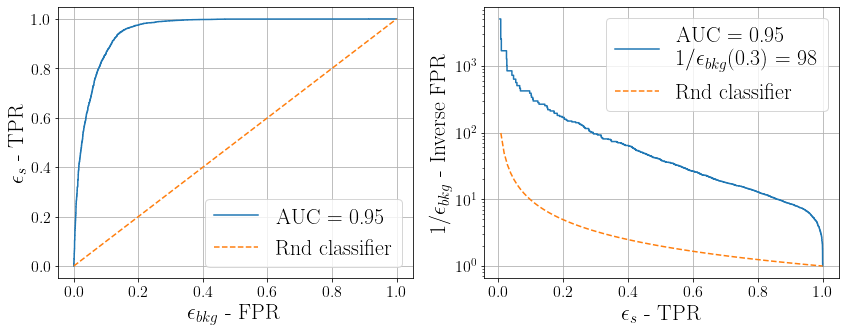

In [157]:
fig, ax = plt.subplots(1, 2, figsize=(14,5))

fpr, tpr, th = roc_curve(y_test[:samp_size], test_pred)
auc_score = roc_auc_score(y_test[:samp_size], test_pred)
rnd_class = np.linspace(0, 1, 100)

ax[0].plot(fpr, tpr, label='AUC = {:.2f}'.format(auc_score) )
ax[0].plot(rnd_class, rnd_class, '--', label='Rnd classifier')
ax[1].plot(tpr, 1/fpr, label='AUC = {:.2f}\n $1/\epsilon_{{bkg}}$(0.3) = {:.0f}'.format(auc_score, 1/fpr[closest_point(tpr, tpr_p=0.3)]))
ax[1].plot(rnd_class, 1/rnd_class, '--', label='Rnd classifier')
ax[1].set_yscale('log')

ax[0].set_xlabel('$\epsilon_{bkg}$ - FPR', fontproperties=axislabelfont)
ax[0].set_ylabel('$\epsilon_{s}$ - TPR', fontproperties=axislabelfont)

ax[1].set_xlabel('$\epsilon_{s}$ - TPR', fontproperties=axislabelfont)
ax[1].set_ylabel('1/$\epsilon_{bkg}$ - Inverse FPR', fontproperties=axislabelfont)
for i in range(len(ax)):
    ax[i].legend(prop=axislabelfont)
    ax[i].tick_params(labelsize=axisfontsize)
    ax[i].grid('on')

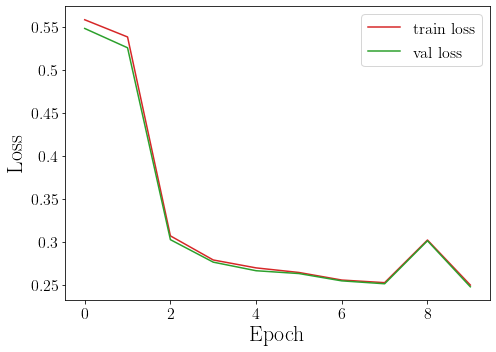

In [158]:
fig, axs = plt.subplots( 1, 1, figsize=(7,5) )

c1 = 'tab:red'
c2 = 'tab:green'

axs.plot( trn_losses, label="train loss", color=c1 )
axs.plot( val_losses, label="val   loss", color=c2 )

#axs.set_yscale('log')

axs.set_xlabel( "Epoch", fontproperties=axislabelfont )
axs.set_ylabel( "Loss", fontproperties=axislabelfont )

xticks = [ int(x) for x in axs.get_xticks() ]
axs.set_xticklabels( xticks, fontproperties=tickfont )

yticks = [ np.round(x,2) for x in axs.get_yticks() ]
axs.set_yticklabels( yticks, fontproperties=tickfont )

axs.legend( loc='best', prop=tickfont )

fig.tight_layout()

This training could definitely benefit from more epochs, some regularisation, and maybe early stopping.  But here we just want to show how to get the DGCNN up and running.